In [1]:
import os
import sys
import time
import copy

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report

from IPython.display import Image

from tqdm.notebook import tqdm



In [2]:
class RandomSphere(Dataset):
    
    """
    Class for generating dataset of a random
    sphere lying in a low dimensional manifold
    embedded in a higher dimensional space
    """
    
    def __init__(self, N=1000, n=100, k=3, r=10.0, D=50.0, max_norm=100.0, mu=10, sigma=5, seed=42):
        
        """
        :param N: total number of samples
        :type N: int
        :param k: low (k)-dimensional manifold 
        :type k: int
        :param n: dimension of manifold in which sphere is embedded
        :type n: int
        :param r: radius of the sphere
        :type r: float
        :param D: clamping limit for negative examples
        :type D: float
        :return: points
        :param max_norm: maximum possible norm that a point can have
        :type max_norm: float
        :param mu: mean of normal distribution from which we sample
        :type: float
        :param sigma: standard deviation of normal distribution from which we sample
        :type: float
        :param seed: random seed (default is the answer to the ultimate question!)
        :type: int
        """
        
        self.N = N
        self.n = n
        self.k = k
        self.r = r
        self.D = D
        self.max_norm = max_norm
        self.mu = mu
        self.sigma = sigma
        self.seed = seed
        
        ## setting seed
        torch.manual_seed(42)
        np.random.seed(42)
        
        self.x_ck = None
        """center of the sphere"""
        
        self.x_cn = None
        """center of sphere in higher dimension"""
        
        self.points_k = None
        """points sampled from the sphere in k-dim"""
        
        self.points_n = None
        """embedding of `self.points_k` in n-dim"""
        
        self.actual_distances = None
        """actual distance of points from the sphere's surface"""
        
        self.distances = None
        """clamped distance of the point from the sphere's surface"""
        
        
        self.translation = np.random.normal(self.mu, self.sigma, self.n)
        """randomly sampled translation transform"""
        
        
        self.gen_center()
        self.gen_points()
        self.embed_in_n()
        self.compute_distances()
        
        self.points_n = torch.from_numpy(self.points_n).float()
        self.points_k = torch.from_numpy(self.points_k).float()
        self.distances = torch.from_numpy(self.distances).float()
        self.actual_distances = torch.from_numpy(self.actual_distances).float()
        
    def __len__(self):
        return self.points_n.shape[0]
    
    def __getitem__(self, idx):
        return self.points_n[idx], self.distances[idx]
        
        
    def gen_center(self):
        """generate a center in lower dimension"""
        self.x_ck = np.random.normal(self.mu, self.sigma, self.k)
        
    def gen_points(self):
        """generating points in k-dim and embedding in n-dim"""
        points_k = np.random.normal(self.mu, self.sigma, (self.N, self.k))
        points_k = points_k - self.x_ck
        
        norms = np.linalg.norm(points_k, axis=1, ord=2).reshape(-1, 1)
        points_k = (points_k / norms)
        
#         print(np.round(np.linalg.norm(points_k, axis=1, ord=2))[np.ceil(np.linalg.norm(points_k, axis=1, ord=2)) > 1])
        
        assert (np.round(np.linalg.norm(points_k, axis=1, ord=2)) == 1).all()
        
        points_k = self.r * points_k
        
        # constructing negative examples
        neg_norms = np.random.uniform(low=1 + np.finfo(np.float).eps,\
                                      high=self.max_norm, size=np.floor(self.N / 2).astype(np.int64))
        
        points_k[:np.floor(self.N / 2).astype(np.int64)] = (neg_norms.reshape(-1, 1) / self.r) * points_k[:np.floor(self.N / 2).astype(np.int64)]
        
        points_k = points_k + self.x_ck
        
        self.points_k = points_k
        
    
    def embed_in_n(self):
        
        # embedding the center
        self.x_cn = np.zeros(self.n)
        self.x_cn[:self.k] = self.x_ck
        self.x_cn = self.x_cn + self.translation         
        
        #embedding the points
        points_n = np.zeros((self.N, self.n))
        points_n[:, :self.k] = self.points_k
        self.points_n = points_n + self.translation

        assert (np.round(np.linalg.norm(self.points_n[np.ceil(self.N / 2).astype(np.int64):] - self.x_cn, axis=1, ord=2)) == self.r).all()

        
    def compute_distances(self):
        
        self.actual_distances = np.linalg.norm(self.points_n - self.x_cn, axis=1, ord=2) - self.r
        self.distances = np.clip(self.actual_distances, a_min=0, a_max=self.D)
        

    
    
    

    
    

In [17]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_sizes=[512, 512, 512, 512]):
        
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        
        layers = [("fcn-0", nn.Linear(self.input_size, hidden_sizes[0])), ("relu-0", nn.ReLU())]
        
        for i in range(len(hidden_sizes) - 1):

            layers.append(("fcn-{n}".format(n=i+1), nn.Linear(hidden_sizes[i], hidden_sizes[i+1])))
            layers.append(("relu-{n}".format(n=i+1), nn.ReLU()))
                    
        layers.append(("fcn-" + str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], 1)))
        
        self.layers = nn.Sequential(OrderedDict(layers))
        
    def forward(self, X):
        
        logits = self.layers(X)
        logits = logits.reshape(-1)
        return logits

In [11]:
def train(model, optimizer, loss, dataloaders, device, num_epochs, save_dir, name="MLP_512x4_in1000"):
    """
        Function to train the model. Also dumps the best model.
        
        Returns the best model and optimizers

    """
    
    TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

    
    model_dir = os.path.join(save_dir, "models")
    plot_dir = os.path.join(save_dir, "plots")
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    
    plot_fn = os.path.join(plot_dir, name + "_" + TIME_STAMP)
    
    liveloss = PlotLosses(fig_path=plot_fn)
    
    phase = "train"
    
    last_best_epoch_loss = None
    
    for epoch in tqdm(range(num_epochs)):
        
        logs = {
            "loss": 0,
            "val_loss": 0
        }
        
        
        
        for phase in ["train", "val"]:
            
            dl = dataloaders[phase]
            
            if phase == "train":
                torch.set_grad_enabled(True)
                model.train()
            else:
                torch.set_grad_enabled(False)
                model.eval()
            
            num_batches = 0
            
            prefix = ""
            if phase == "val":
                prefix = "val_"
            
            for (i, batch) in enumerate(dataloaders[phase]):
                
                points = batch[0].to(device)
                distances = batch[1].to(device)
                
                model.zero_grad()
                model = model.to(device)
                
                logits = model(points)
                
                loss = loss_func(distances, logits)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                    
                logs[prefix + "loss"] += loss.detach().cpu().item()
                
                num_batches = i
            
            # dividing by the number of batches
            logs[prefix + "loss"] /= num_batches
            
        if last_best_epoch_loss is None or logs["val_loss"] < last_best_epoch_loss:
            last_best_epoch_loss = logs["val_loss"]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': logs['val_loss'],
                'loss': logs["loss"]
            }, os.path.join(model_dir, NAME + "_"+ TIME_STAMP + "val_loss_" + str(logs["val_loss"]) + ".pth"))

        
            
        liveloss.update(logs)
        liveloss.draw()
        
    return models, optimizer
            
            


In [5]:
train_params = {
    "N": 200000,
    "n": 1000,
    "k": 3,
    "r": 10.0,
    "D": 50.0,
    "max_norm": 100.0,
    "mu": 10,
    "sigma": 5,
    "seed": 42
}

val_params = {
    "N": 100000,
    "n": 1000,
    "k": 3,
    "r": 10.0,
    "D": 50.0,
    "max_norm": 100.0,
    "mu": 10,
    "sigma": 5,
    "seed": 101
}

test_params = {
    "N": 100000,
    "n": 1000,
    "k": 3,
    "r": 10.0,
    "D": 50.0,
    "max_norm": 100.0,
    "mu": 10,
    "sigma": 5,
    "seed": 79
}

train_set = RandomSphere(**train_params)
val_set = RandomSphere(**val_params)
test_set = RandomSphere(**test_params)


In [6]:
BATCH_SIZE = 2048
NUM_WORKERS = 9

dataloaders = {
    "train": DataLoader(dataset=train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "val": DataLoader(dataset=val_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    "test": DataLoader(dataset=test_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
}

In [19]:
model = MLP(1000)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005, lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NAME = "MLP_in1000_H512x4_o1"
SAVE_DIR = "../dumps/expB_learning_distance_from_mfld"

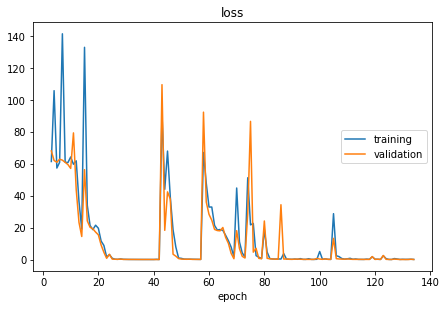

loss:
training   (min:    0.052, max:  278.425, cur:    0.105)
validation (min:    0.050, max:  109.511, cur:    0.057)


KeyboardInterrupt: 

In [20]:
model, optimizer = train(model, optimizer, loss_func, dataloaders, device, num_epochs=10000, save_dir=SAVE_DIR, name=NAME)



In [18]:
model = MLP(1000)
model

MLP(
  (layers): Sequential(
    (fcn-0): Linear(in_features=1000, out_features=512, bias=True)
    (relu-0): ReLU()
    (fcn-1): Linear(in_features=512, out_features=512, bias=True)
    (relu-1): ReLU()
    (fcn-2): Linear(in_features=512, out_features=512, bias=True)
    (relu-2): ReLU()
    (fcn-3): Linear(in_features=512, out_features=512, bias=True)
    (relu-3): ReLU()
    (fcn-4): Linear(in_features=512, out_features=1, bias=True)
  )
)